# Cleaning University of Central Florida's Power Consumption Dataset
The data retrieved from [UCF's energy dashboard](http://oeis.ucf.edu/buildings/85) regarding power consumption in UCF's Engineering (Harris Corporation Engineering Center) building is in the form of a json format. Here we'll be converting it into a csv file for later data analysis.

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pprint
from datetime import datetime
import requests

In [21]:
#Helper functions

#Conversion from kBTU (Current unit) to kWH (Metric System)
def convert_kwh(kbtu_unit):
    return kbtu_unit * 0.29307106944 

#Conversion of dates into datetime objects
def convert_dates(dates):
    return [datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

In [22]:
#Making requests
def make_request(building_num):
    url = "http://oeis.ucf.edu/getData"
    payload = '_token=sFBqgPA01sMv6Eo4MSKYCKWYuH1PDgv5W9nCylMA&building='+ str(building_num) + '&end-date=01/01/2020&filetype=json&resolution=day&start-date=01/01/2016'
    headers = {
      'Content-Type': 'application/x-www-form-urlencoded',
    }
    response = requests.request("POST", url, headers=headers, data = payload)
    return response.json()

In [23]:
#Parse JSON string into dataframe for power
def parse_json(json_string):
    count = 0
    data = json_string[0]
    
    df_power = pd.DataFrame(columns = ['Power', 'Date'])
    df_power.head()
    
    readings = data['values']

    for entry in readings:
        #Get corresponding values
        date = entry['timestamp']
        if (entry['reading'] is None):
            power = None
            count += 1
        else: 
            power = convert_kwh(float(entry['reading']))

        #Add to dataframe
        df_power = df_power.append({"Power": power, "Date": date}, ignore_index=True)

    print(count)
    df_power['Weekday'] = get_weekday(df_power['Date'])
    return df_power

In [24]:
#Merge weather data and power data 
def merge_weather(df_power, weather_data='Datasets/Orlando_Weather.csv'):
    #Read data, drop unused columns and remove 0 values
    df_weather = pd.read_csv(weather_data)
    df_weather = df_weather.drop(columns=['Hour', 'Minute', 'Surface Albedo'])
    df_weather = df_weather[df_weather.DNI != 0]
    
    #Take mean, max and min for each DNI and Temperature in DataFrame and mean for everything else
    max_temp = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['Temperature']
    min_temp = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['Temperature']
    
    #Split into Y M and D
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    

    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    df_weather.insert(11, 'Temp Max', max_temp)
    df_weather.insert(12, 'Temp Min', min_temp)
    
    df_power[['Year', 'Month', 'Day']] = df_power.Date.str.split('-', expand=True).apply(pd.to_numeric)

    #Merge data together
    df_merge = df_weather.merge(df_power[['Power', 'Year','Month', 'Day', 'Weekday']], left_on=('Year', 'Month', 'Day'), 
                                right_on=('Year', 'Month', 'Day'), how = 'inner', suffixes=('_left','_right'))
    df_merge = df_merge.rename(columns={'Power': 'Power Consumption', 'DNI':'DNI Mean'})
    
    return df_merge

In [25]:
#Simplified lambda expression for doing all three steps at once.
gen_data = lambda building_id : merge_weather(parse_json(make_request(building_id)))

In [26]:
#List of datapoints we're interested in.
data = pd.read_csv("Datasets/UCF_Keys.csv")
data.head()

,Key,University Name,Building Name,Square Feet,Type
0,85,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
1,154,University of Central Florida,Research I,105775,Laboratory
2,101,University of Central Florida,Physical Sciences Building,128887,Laboratory
3,123,University of Central Florida,Biological Sciences Building,116607,Laboratory
4,112,University of Central Florida,CREOL Building,111891,Laboratory


In [27]:
#Add all rows to common DataFrame, with diffrentiating factors included

df = pd.DataFrame()

for i in range(0, len(data)):
    print(str(i + 1) + ", ", end = '')
    current_df = gen_data(data['Key'][i])
    current_df['University Name'] = data['University Name'][i]
    current_df['Building Name'] = data['Building Name'][i]
    current_df['Square Feet'] = data['Square Feet'][i]
    current_df['Type'] = data['Type'][i]
    df = df.append(current_df)
    
df.head()

1, 194
2, 731
3, 0
4, 0
5, 13
6, 0
7, 16
8, 0
9, 0
10, 0
11, 0
12, 0
13, 0
14, 3


,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
0,2016,1,1,486.888889,842,268,2.422222,3.234556,242.222222,67.927778,26.555556,29.0,23.0,1010.000000,NaN,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
1,2016,1,2,359.571429,798,75,2.542857,3.927857,17.157143,64.734286,21.142857,22.0,20.0,1010.000000,NaN,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
2,2016,1,3,12.500000,16,9,2.900000,3.777000,342.800000,77.350000,15.000000,16.0,14.0,1010.000000,NaN,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
3,2016,1,4,693.363636,958,190,3.281818,1.277273,318.000000,50.267273,14.363636,18.0,8.0,1010.000000,NaN,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
4,2016,1,5,457.888889,907,123,5.677778,1.326667,49.055556,57.557778,17.000000,19.0,14.0,1016.666667,NaN,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom


In [28]:
df.shape

(20426, 20)

In [29]:
#Removing massive outliers 
df = df.dropna()
df = df[df['Power Consumption'] > 200]
df = df[df['Power Consumption'] < 40000]

df

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
220,2016,8,10,310.769231,850,11,2.115385,5.775000,122.123077,81.439231,28.846154,31.0,24.0,1010.000000,5289.221903,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
221,2016,8,11,458.363636,846,2,1.945455,5.990364,110.290909,79.874545,29.090909,31.0,25.0,1010.000000,6232.404214,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
222,2016,8,12,419.000000,882,31,2.191667,5.054167,138.166667,76.782500,29.166667,32.0,25.0,1010.000000,6484.952963,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
223,2016,8,13,498.666667,904,47,2.366667,4.021750,141.116667,73.201667,29.666667,33.0,25.0,1010.000000,6098.378307,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
224,2016,8,14,47.666667,97,8,2.588889,5.230667,107.488889,81.852222,28.888889,30.0,26.0,1010.000000,6235.404728,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2019,12,27,89.636364,275,3,3.718182,3.081818,84.545455,83.821818,23.100000,24.9,19.7,1016.272727,3033.946205,0,University of Central Florida,Chemistry Building,49073,Laboratory
1455,2019,12,28,58.000000,132,5,4.050000,3.900000,112.875000,86.521250,23.812500,25.2,20.3,1014.875000,3032.025824,1,University of Central Florida,Chemistry Building,49073,Laboratory
1456,2019,12,29,116.636364,262,3,3.663636,3.790909,152.818182,87.425455,24.427273,26.3,21.5,1012.272727,3022.784033,1,University of Central Florida,Chemistry Building,49073,Laboratory
1457,2019,12,30,48.090909,192,3,3.009091,4.254545,220.090909,86.351818,23.945455,25.9,21.2,1009.818182,3018.823261,0,University of Central Florida,Chemistry Building,49073,Laboratory


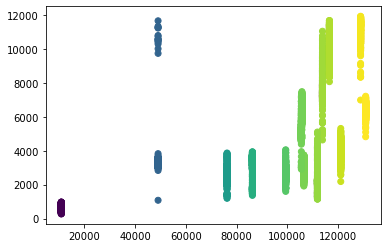

In [30]:
#Exploratory Analysis between Temperature and Power Consumption
import matplotlib.pyplot as plt

df1 = df[df['Year'] == 2019]
plt.scatter(df1['Square Feet'], df1['Power Consumption'], c = df1['Square Feet'])

# plt.scatter(df['Square Feet'], df['Power Consumption'], c = df['Square Feet'])
plt.show()

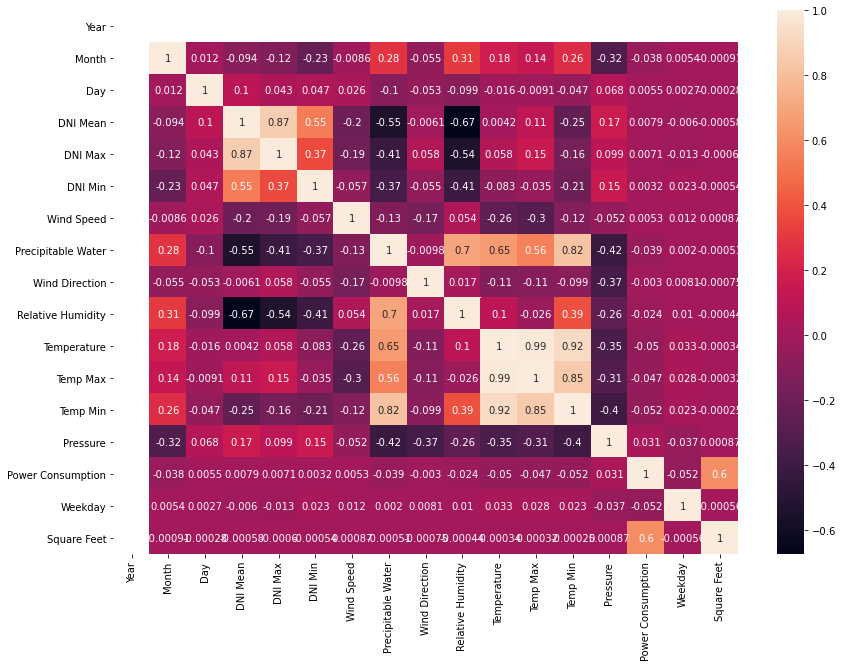

In [31]:
plt.figure(figsize=(14,10))
sns.heatmap(df1.corr(), annot=True)
plt.show()

In [32]:
#Saving data to file
df.to_csv('Datasets/UCF_PowerWeatherData.csv', index=False)

In [33]:
#Merging data
df1 = pd.read_csv('Datasets/UCF_PowerWeatherData.csv')
df2 = pd.read_csv('Datasets/UCB_PowerWeatherData.csv')
df_merge = pd.concat([df1, df2], axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

df_merge.head()

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Temp Max,Temp Min,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
0,2016,8,10,310.769231,850,11,2.115385,5.775000,122.123077,81.439231,28.846154,31.0,24.0,1010.0,5289.221903,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
1,2016,8,11,458.363636,846,2,1.945455,5.990364,110.290909,79.874545,29.090909,31.0,25.0,1010.0,6232.404214,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
2,2016,8,12,419.000000,882,31,2.191667,5.054167,138.166667,76.782500,29.166667,32.0,25.0,1010.0,6484.952963,0,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
3,2016,8,13,498.666667,904,47,2.366667,4.021750,141.116667,73.201667,29.666667,33.0,25.0,1010.0,6098.378307,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom
4,2016,8,14,47.666667,97,8,2.588889,5.230667,107.488889,81.852222,28.888889,30.0,26.0,1010.0,6235.404728,1,University of Central Florida,Harris Corporation Engineering Center,113866,Classroom


In [34]:
np.where(pd.isnull(df_merge))

(array([], dtype=int64), array([], dtype=int64))

In [35]:
print(df_merge.shape)
df_merge = df_merge.dropna()
print(df_merge.shape)

(28747, 20)
(28747, 20)


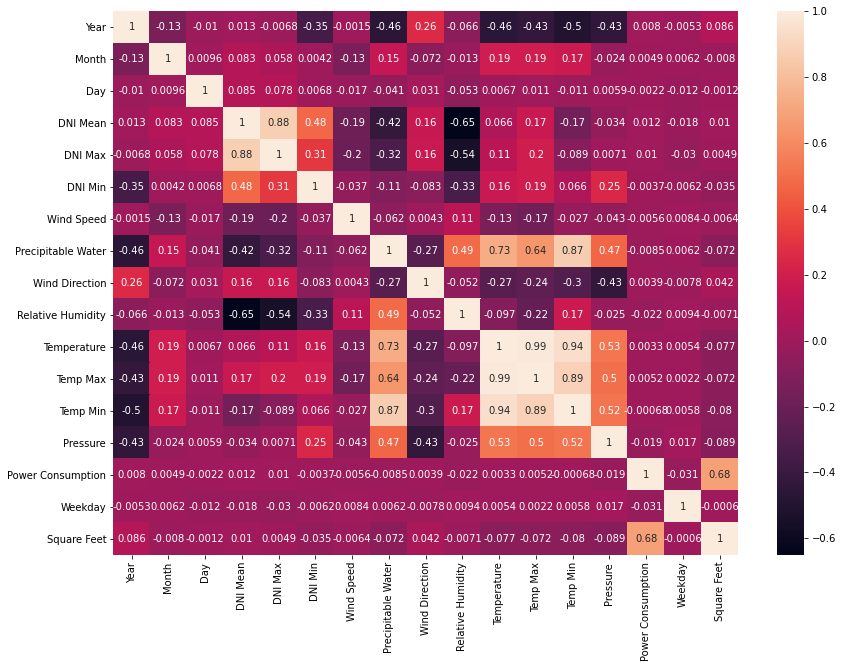

In [36]:
plt.figure(figsize=(14,10))
sns.heatmap(df_merge[df_merge['Type'] == 'Laboratory'].corr(), annot=True)
plt.show()

In [38]:
df_merge.to_csv('Datasets/Combined_PowerWeatherData2.csv', index=False)